In [118]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy

from data import utils
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import FastICA, PCA

alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)
N = 1000 # can try looping for best N later

RI0 = np.random.rand(D, N)
RI0 = np.where(RI0>0.5, 1, -1)

RI1 = np.random.rand(D, N)
RI1 = np.where(RI1>0.5, 1, -1)

def read_csv(filepath):
    pres, past, freq = [], [], []
    with open(filepath, "rb") as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        for row in reader:
            pres.append(row[0])
            past.append(row[1])
            freq.append(float(row[2]))
    freq = np.asarray(freq)
    return pres, past, freq/np.sum(freq)

def ngram_encode(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.' 
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

def encodes(words, RI, window=3, N=N):
    num_words = len(words)
    X = np.zeros((num_words, N))
    for i in range(num_words):
        X[i] = ngram_encode_cl(words[i], RI, window)
    return X

def gen_diffs(present, past, RI_pres, RI_past, ngram_length):
    X = np.zeros((len(past), N))
    for i in range(X.shape[0]):
        X[i] = (ngram_encode(past[i], RI_past, ngram_length) 
                        - ngram_encode(present[i], RI_pres, ngram_length))
        
    #return normalize(X,axis=0)
    return X

# psi = np.sum(reg_pres1[:reg_traini]*reg_X[:reg_traini], axis=0)
def map_train(pres1, X, pres0=None, epochs=1):
    return np.sum(np.multiply(pres1,X), axis=0)

def perceptron_map_train(pres1, X, pres0, epochs=1):
    psi = np.zeros(N) #psi
    num_wrong = 0
    for e in range(epochs):
        for i in range(X.shape[0]):
            # if predict correctly, add to total_vec with a smaller weight
            train_pred = np.multiply(pres1[i], psi) + pres0[i]
            train_sim = np.dot(train_pred, pres0[i])
            random_sim = np.dot(np.random.randn(N), pres0[i]) 
            # this almost always holds true now
            if train_sim > random_sim:
                psi += ((N-train_pred)/float(N)) * np.multiply(pres1[i],X[i])
            else:
                num_wrong += 1
                print ("NUM_WRONG: ", num_wrong)
                psi += np.multiply(pres1[i],X[i])
    return psi

# pred_past, past same length
def sim(pred_past, past):
    data1, data3 = np.zeros(past.shape[0]), np.zeros(past.shape[0])
    total1, total3, count = 0, 0, 0
    
    random_vecs = np.random.randn(past.shape[0], N)
    
    for j in range(past.shape[0]):
        sim1 = np.dot(pred_past[j], past[j])
        total1 += sim1

        # fixed: a typo where similarity of random 
        # compared to present instead of past. 
        # need to be consistent
        sim3 = np.dot(random_vecs[j], past[j])
        total3 += sim3

        count += 1
        data1[j] = sim1 #sim1/float(count) #total1/float(count)
        data3[j] = sim3 #sim3/float(count) #total3/float(count)

    return data1, data3
# map_train, epochs, reg_X[:reg_traini], reg_X[reg_traini:]
#def graph(train_func, train_X, test_X, epochs, title):
def graph(train_func, X, pres0, pres1, past0, past1, traini, epochs, title):
    test_m = np.arange(1, traini, 1)

    train_dot = np.zeros_like(test_m)
    test_dot = np.zeros_like(test_m) # np.zeros(test_m.shape)
    random_dot = np.zeros_like(test_m)
    print pres0[traini:].shape
    print pres1[traini:].shape
    for im, m in enumerate(test_m):
        # for increasing training set size
        psi = train_func(pres1[:int(m)], X[:int(m)], pres0[:int(m)], epochs=1)
        train_pred_past0 = np.multiply(pres1[:int(m)], psi) + pres0[:int(m)]
        #print (train_pred_past0.shape, pres0[traini:].shape)
        test_pred_past0 = np.multiply(pres1[traini:], psi) + pres0[traini:]
        d1, d3 = sim(train_pred_past0, X[:int(m)])
        d2, d4 = sim(test_pred_past0, X[traini:])
        
        train_dot[im] = d1.mean()
        test_dot[im] = d2.mean()
        random_dot[im] = d3.mean()

    fig = plt.figure()
    plt.plot(test_m, train_dot)
    plt.plot(test_m, random_dot)
    plt.plot(test_m, test_dot)
    fig.suptitle(title, fontsize=20)
    plt.xlabel('number of words', fontsize=18)
    plt.ylabel('average dot product', fontsize=16)
    plt.show()
    #fig.savefig('test.jpg')

In [119]:
train_ratio = 2/3.0
epochs = 1
irreg_weight = 1;
ngram_length = 3;
n_components = 20;
# regulars
txt_to_graph = ["jumped", "made", "brought", "determined", "offset", \
                "paid", "chid", "robbed"]
# irregulars
txt_to_graph += ["put", "bent", "swept", "caught", "wrote", "met", \
               "rang", "rose", "struck", "saw"]

In [120]:
regular_present, regular_past, regular_freq = read_csv("data/cleaned/regular_verbs_clean.csv")
irregular_present, irregular_past, irregular_freq = read_csv("data/cleaned/irregular_verbs_clean.csv")
irregular_freq = irreg_weight*irregular_freq
# no need to shuffle?
present = regular_present + irregular_present
past = regular_past + irregular_past
freq = np.concatenate((regular_freq, irregular_freq),axis=0)

num_reg = regular_freq.shape[0]
num_irreg = irregular_freq.shape[0]
reg_traini = int(num_reg*train_ratio)
irreg_traini = int(num_irreg*train_ratio)
traini = reg_traini + irreg_traini

reg_pres_train, reg_pres_test = regular_present[:int(num_reg*train_ratio)], regular_present[int(num_reg*train_ratio):]
reg_past_train, reg_past_test = regular_past[:int(num_reg*train_ratio)], regular_past[int(num_reg*train_ratio):]

irreg_pres_train, irreg_pres_test = irregular_present[:int(num_irreg*train_ratio)], irregular_present[int(num_irreg*train_ratio):]
irreg_past_train, irreg_past_test = irregular_past[:int(num_irreg*train_ratio)], irregular_past[int(num_irreg*train_ratio):]

pres_train, pres_test = reg_pres_train + reg_past_train, reg_pres_test + reg_past_test
past_train, past_test = irreg_pres_train + irreg_past_train, irreg_pres_test + reg_past_test

In [121]:
# encodings of every pair for both dictionaries
reg_pres0 = encodes(regular_present, RI0)
irreg_pres0 = encodes(irregular_present, RI0)
pres0 = np.concatenate((reg_pres0, irreg_pres0), axis=0)

reg_pres1 = encodes(regular_present, RI1)
irreg_pres1 = encodes(irregular_past, RI1)
pres1 = np.concatenate((reg_pres1, irreg_pres1), axis=0)
 
reg_past1 = encodes(regular_past, RI1)
irreg_past1 = encodes(irregular_past, RI1)
past1 = np.concatenate((reg_past1, irreg_past1), axis=0)

reg_past0 = encodes(regular_past, RI0) 
irreg_past0 = encodes(irregular_past, RI0)
past0 = np.concatenate((reg_past0, irreg_past0), axis=0)

In [122]:
print (reg_pres0.shape, irreg_pres0.shape, pres0.shape)
print (reg_pres1.shape, irreg_pres1.shape, pres1.shape)
print (reg_past1.shape, irreg_past1.shape, past1.shape)
print (reg_past0.shape, irreg_past0.shape, past0.shape)
#print (pres0.shape, pres1.shape, past0.shape, past1.shape)

((2448, 1000), (189, 1000), (2637, 1000))
((2448, 1000), (189, 1000), (2637, 1000))
((2448, 1000), (189, 1000), (2637, 1000))
((2448, 1000), (189, 1000), (2637, 1000))


In [123]:
reg_X = gen_diffs(regular_present, regular_past, RI0, RI0, ngram_length)
irreg_X = gen_diffs(irregular_present, irregular_past, RI0, RI0, ngram_length)
X = gen_diffs(present, past, RI0, RI0, ngram_length)
"""
pca = PCA(n_components=n_components)
reg_pca = pca.fit(reg_X).transform(reg_X)
irreg_pca = pca.fit(irreg_X).transform(irreg_X)
_pca = pca.fit(X).transform(X)
print (reg_pca.shape, irreg_pca.shape, _pca.shape)
"""

#((9, 6), (6, 6), (6,))#((9, 6), (6, 6), (6,))
U, s, V = np.linalg.svd(X, full_matrices=False)
S = np.diag(s)
regU, regs, regV = np.linalg.svd(reg_X, full_matrices=False)
regS = np.diag(regs)
irregU, irregs, irregV = np.linalg.svd(irreg_X, full_matrices=False)
irregS = np.diag(irregs)

In [124]:
svd = np.dot(U[:,:n_components],np.dot(np.diag(s[:n_components]), V[:n_components, :]))
reg_svd = np.dot(regU[:,:n_components],np.dot(np.diag(regs[:n_components]), regV[:n_components, :]))
irreg_svd = np.dot(irregU[:,:n_components],np.dot(np.diag(irregs[:n_components]), irregV[:n_components, :]))

(63, 1000)
(63, 1000)


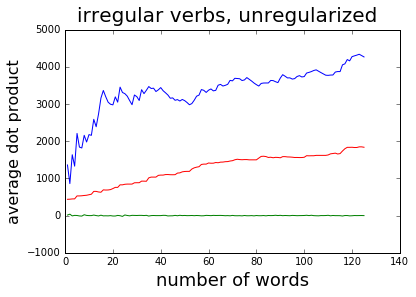

(63, 1000)
(63, 1000)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRONG: ', 2)
('NUM_WRONG: ', 1)
('NUM_WRO

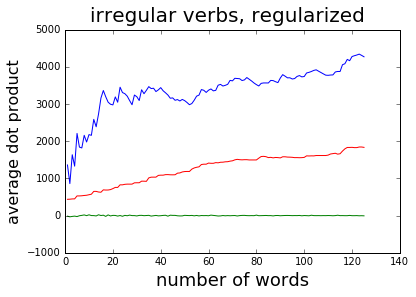

In [125]:
# sim -> regularization is wrong

# 1. regular verbs, unregularized
#graph(map_train, reg_svd, reg_pres0, reg_pres1, reg_past0, reg_past1, reg_traini, epochs, "regular verbs, unregularized")
# 2. regular verbs, regularized
#graph(perceptron_map_train, reg_svd, reg_pres0, reg_pres1, reg_past0, reg_past1, reg_traini, epochs, "regular verbs, regularized")
# 3. irregular verbs, unregularized
graph(map_train, irreg_svd, irreg_pres0, irreg_pres1, irreg_past0, irreg_past1, irreg_traini, epochs, "irregular verbs, unregularized")
# 4. irregular verbs, regularized
graph(perceptron_map_train, irreg_svd, irreg_pres0, irreg_pres1, irreg_past0, irreg_past1, irreg_traini, epochs, "irregular verbs, regularized")
# 5. regular and irregular verbs, unregularized
#graph(map_train, svd, pres0, pres1, past0, past1, traini, epochs, "all verbs, unregularized")
# 6. regular and irregular verbs, regularized
#graph(perceptron_map_train, svd, pres0, pres1, past0, past1, traini, epochs, "all verbs, regularized")


In [ ]:
# running more epochs decreases test accuracy for some reason